#### Problem Statement :  We want to Predict if passenger survived the sinking of the Titanic or not.

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import classification_report

In [2]:
df = pd.read_csv('train_titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
m = df.isna().sum()
m[m>0]

Age         177
Cabin       687
Embarked      2
dtype: int64

In [5]:
df.duplicated().sum()

0

### Drop the unnesesarry columns/data field from the x(dependent feature like 'PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived')

In [6]:
x = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived'])
y = df[['Survived']]

In [7]:
x.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [8]:
y.head()

,Survived
0,0
1,1
2,1
3,1
4,0


### here we need to seperate categorical and continuoud features from dependent variable.

In [9]:
#Seperate cat and con features for x
cat = list(x.columns[x.dtypes=='object'])
con = list(x.columns[x.dtypes!='object'])

In [10]:
cat

['Sex', 'Embarked']

In [11]:
con

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

### Here we create a preprocessing pipeline using sklearn library to handel missing values

In [12]:
num_pipe = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                           ('scaler', StandardScaler())])

cat_pipe = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                           ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

pre = ColumnTransformer([('num', num_pipe, con),
                         ('cat', cat_pipe, cat)]).set_output(transform='pandas')

In [13]:
x_pre = pre.fit_transform(x)
x_pre.head()

,num__Pclass,num__Age,num__SibSp,num__Parch,num__Fare,cat__Sex_female,cat__Sex_male,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S
0,0.827377,-0.497793,0.432793,-0.473674,-0.502445,0.0,1.0,0.0,0.0,1.0
1,-1.566107,0.715048,0.432793,-0.473674,0.786845,1.0,0.0,1.0,0.0,0.0
2,0.827377,-0.194583,-0.474545,-0.473674,-0.488854,1.0,0.0,0.0,0.0,1.0
3,-1.566107,0.487640,0.432793,-0.473674,0.420730,1.0,0.0,0.0,0.0,1.0
4,0.827377,0.487640,-0.474545,-0.473674,-0.486337,0.0,1.0,0.0,0.0,1.0


### here we pass the data to traning and testing as 80:20 ratio 

In [14]:
xtrain, xtest, ytrain, ytest = train_test_split(x_pre, y, test_size=0.2, random_state=42)

In [15]:
xtrain.head()

,num__Pclass,num__Age,num__SibSp,num__Parch,num__Fare,cat__Sex_female,cat__Sex_male,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S
331,-1.566107,1.283567,-0.474545,-0.473674,-0.074583,0.0,1.0,0.0,0.0,1.0
733,-0.369365,-0.421991,-0.474545,-0.473674,-0.386671,0.0,1.0,0.0,0.0,1.0
382,0.827377,0.260233,-0.474545,-0.473674,-0.488854,0.0,1.0,0.0,0.0,1.0
704,0.827377,-0.194583,0.432793,-0.473674,-0.490280,0.0,1.0,0.0,0.0,1.0
813,0.827377,-1.710635,3.154809,2.008933,-0.018709,1.0,0.0,0.0,0.0,1.0


In [16]:
ytrain.head()

,Survived
331,0
733,0
382,0
704,0
813,0


In [17]:
xtrain.shape

(712, 10)

In [18]:
xtest.shape

(179, 10)

### ALgo Evaluation
here create a dictionary of several algorithms to find which one is best suitable for titanic survived.

In [19]:
dct = {'Logistic': LogisticRegression(),
       'Decision Tree' : DecisionTreeClassifier(),
       'Random Forest': RandomForestClassifier(),
       'Gradient Boost': GradientBoostingClassifier(),
       'KNN': KNeighborsClassifier(),
       'SVM': SVC()}

In [20]:
dct.items()

dict_items([('Logistic', LogisticRegression()), ('Decision Tree', DecisionTreeClassifier()), ('Random Forest', RandomForestClassifier()), ('Gradient Boost', GradientBoostingClassifier()), ('KNN', KNeighborsClassifier()), ('SVM', SVC())])

In [21]:
tr = []
tr_cv = []
ts = []
for name, model in dct.items():
    # Fit the model
    model.fit(xtrain, ytrain)
    # Predict results for train and test
    ypred_tr = model.predict(xtrain)
    ypred_ts = model.predict(xtest)
    # Calculate f1 score in train and test
    f1_tr = f1_score(ytrain, ypred_tr)
    f1_ts = f1_score(ytest, ypred_ts)
    # 5 - fold cross validation on training
    scores = cross_val_score(model, xtrain, ytrain, cv=5, scoring='f1_macro')
    f1_cv = scores.mean()
    # Append above results in tr, ts, tr_cv
    tr.append(f1_tr)
    ts.append(f1_ts)
    tr_cv.append(f1_cv)
    # Print above results for each model
    print(f'Model name : {name}\n')
    print(f'Train F1 : {f1_tr:.4f}')
    print(f'Train F1 Cross Validated : {f1_cv:.4f}')
    print(f'Test F1 : {f1_ts:.4f}')
    print('\n=========================================================================\n')

Model name : Logistic

Train F1 : 0.7280
Train F1 Cross Validated : 0.7799
Test F1 : 0.7465


Model name : Decision Tree

Train F1 : 0.9713
Train F1 Cross Validated : 0.7369
Test F1 : 0.7152




Model name : Random Forest

Train F1 : 0.9714
Train F1 Cross Validated : 0.7837
Test F1 : 0.7586


Model name : Gradient Boost

Train F1 : 0.8577
Train F1 Cross Validated : 0.7994
Test F1 : 0.7536


Model name : KNN

Train F1 : 0.8134
Train F1 Cross Validated : 0.7818
Test F1 : 0.7413


Model name : SVM

Train F1 : 0.7732
Train F1 Cross Validated : 0.8042
Test F1 : 0.7660




In [22]:
tr

[0.7279843444227007,
 0.97131931166348,
 0.9714285714285714,
 0.8577235772357723,
 0.8133595284872297,
 0.7731755424063116]

In [23]:
ts

[0.7464788732394366,
 0.7152317880794701,
 0.7586206896551724,
 0.7536231884057971,
 0.7412587412587412,
 0.7659574468085106]

In [24]:
tr_cv

[0.7798956574669025,
 0.736864714383816,
 0.7837125464744128,
 0.7994048805395109,
 0.7817562864287904,
 0.8042494044636325]

In [25]:
dct

{'Logistic': LogisticRegression(),
 'Decision Tree': DecisionTreeClassifier(),
 'Random Forest': RandomForestClassifier(),
 'Gradient Boost': GradientBoostingClassifier(),
 'KNN': KNeighborsClassifier(),
 'SVM': SVC()}

In [26]:
list(dct.keys())

['Logistic', 'Decision Tree', 'Random Forest', 'Gradient Boost', 'KNN', 'SVM']

In [27]:
results_dct = {'Model_name' : list(dct.keys()),
               'Train F1':tr,
               'Test F1':ts,
               'Train F1 CV':tr_cv}

In [28]:

results_df = pd.DataFrame(results_dct)
results_df

,Model_name,Train F1,Test F1,Train F1 CV
0,Logistic,0.727984,0.746479,0.779896
1,Decision Tree,0.971319,0.715232,0.736865
2,Random Forest,0.971429,0.758621,0.783713
3,Gradient Boost,0.857724,0.753623,0.799405
4,KNN,0.813360,0.741259,0.781756
5,SVM,0.773176,0.765957,0.804249


In [29]:
results_df = results_df.sort_values(by='Test F1', ascending=False)
results_df

,Model_name,Train F1,Test F1,Train F1 CV
5,SVM,0.773176,0.765957,0.804249
2,Random Forest,0.971429,0.758621,0.783713
3,Gradient Boost,0.857724,0.753623,0.799405
0,Logistic,0.727984,0.746479,0.779896
4,KNN,0.813360,0.741259,0.781756
1,Decision Tree,0.971319,0.715232,0.736865


### On the basis of above prediction we analyze that the out of all algorithm testing and cross validation result is best for SVM() model (test : 0.7 and cvr:0.8) thats why we use a SVM() model for further predictions

### create a SVM Model

In [30]:
best_model = SVC(probability=True)
best_model.fit(xtrain, ytrain)

SVC(probability=True)

In [31]:
best_model.score(xtrain, ytrain)

0.8384831460674157

In [32]:
best_model.score(xtest, ytest)

0.8156424581005587

In [33]:
ypred_tr = best_model.predict(xtrain)
ypred_ts = best_model.predict(xtest)

In [34]:
ypred_tr[0:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [35]:
ypred_ts[0:5]

array([0, 0, 0, 1, 1], dtype=int64)

In [36]:
ytrain.head()

,Survived
331,0
733,0
382,0
704,0
813,0


In [37]:
ypred_ts[0:5]

array([0, 0, 0, 1, 1], dtype=int64)

In [38]:
ytest.head()

,Survived
709,1
439,0
840,0
720,1
39,1


### Create a Confussion MAtrix

In [39]:
c = best_model.classes_
c

array([0, 1], dtype=int64)

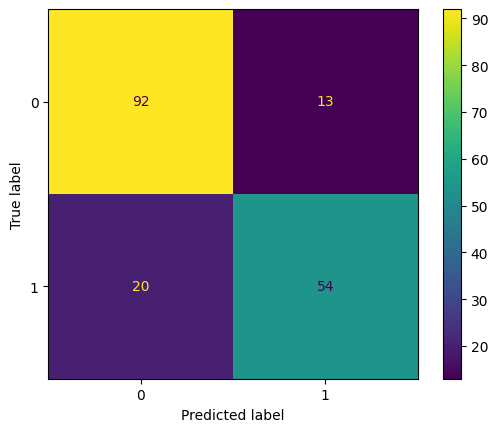

In [40]:
cf = confusion_matrix(ytest, ypred_ts)
cfd = ConfusionMatrixDisplay(cf, display_labels=c)
cfd.plot()

In [41]:
print(classification_report(ytest, ypred_ts))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       105
           1       0.81      0.73      0.77        74

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.82      0.82      0.81       179



### Let's visualize using ROC AUC curve both train and test data 

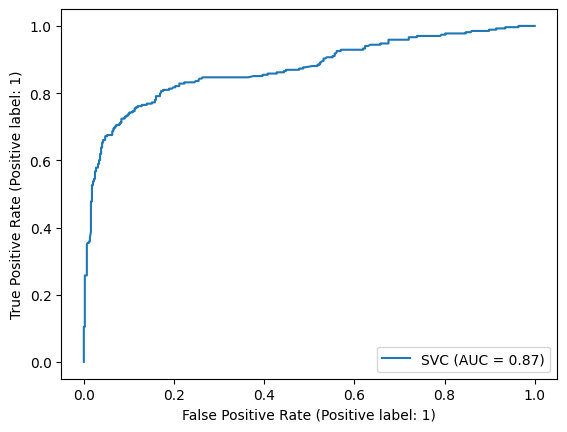

In [42]:
# ROC curve for training data
RocCurveDisplay.from_estimator(best_model, xtrain, ytrain)

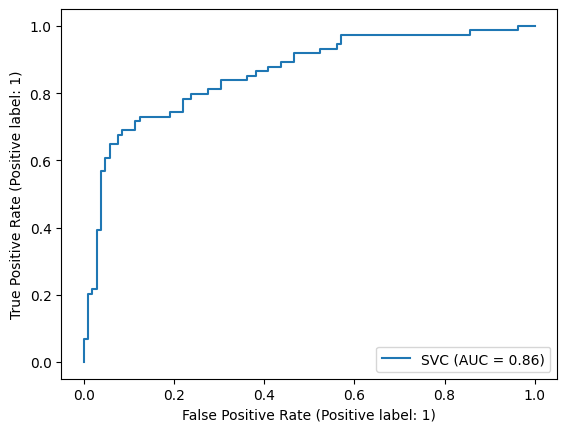

In [43]:
# ROC curve for testing data
RocCurveDisplay.from_estimator(best_model, xtest, ytest)

In [44]:
auc_scores = cross_val_score(best_model, xtrain, ytrain, cv=10, scoring='roc_auc')
auc_scores

array([0.92510288, 0.80164609, 0.71709402, 0.93418803, 0.89814815,
       0.75505051, 0.84848485, 0.78872054, 0.75925926, 0.91161616])

In [45]:
auc_scores.mean()

0.8339310483754927

### On the basis of auc_scores mean the ROC_AUC score > 0.8.It is shows the created model ig good model for titanic survived

### let's predict out of sample data 

In [46]:
xnew = pd.read_csv('test_titanic.csv')
xnew.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [47]:
pre

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('scaler', StandardScaler())]),
                                 ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Sex', 'Embarked'])])

In [48]:
xnew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


### let's handel missing values using created preprocessing pipeline only nedd to transform sample data to the pipelen


In [49]:
xnew_pre = pre.transform(xnew)
xnew_pre.head()

,num__Pclass,num__Age,num__SibSp,num__Parch,num__Fare,cat__Sex_female,cat__Sex_male,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S
0,0.827377,0.449739,-0.474545,-0.473674,-0.490783,0.0,1.0,0.0,1.0,0.0
1,0.827377,1.397271,0.432793,-0.473674,-0.507479,1.0,0.0,0.0,0.0,1.0
2,-0.369365,2.534310,-0.474545,-0.473674,-0.453367,0.0,1.0,0.0,1.0,0.0
3,0.827377,-0.118780,-0.474545,-0.473674,-0.474005,0.0,1.0,0.0,0.0,1.0
4,0.827377,-0.497793,0.432793,0.767630,-0.401017,1.0,0.0,0.0,0.0,1.0


In [50]:
preds = best_model.predict(xnew_pre)
preds

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [51]:
best_model.classes_

array([0, 1], dtype=int64)

In [52]:
probs = best_model.predict_proba(xnew_pre)[:,1]
probs[0:5]

array([0.15440225, 0.5479468 , 0.14730477, 0.14847875, 0.55347955])

### Save the above results in dataframe

In [53]:
df_final = xnew[['PassengerId']]
df_final

,PassengerId
0,892
1,893
2,894
3,895
4,896
...,...
413,1305
414,1306
415,1307
416,1308


In [54]:
df_final['Survived_pred']=preds
df_final['Survived_prob']=probs

In [55]:
df_final

,PassengerId,Survived_pred,Survived_prob
0,892,0,0.154402
1,893,1,0.547947
2,894,0,0.147305
3,895,0,0.148479
4,896,1,0.553480
...,...,...,...
413,1305,0,0.147424
414,1306,1,0.869334
415,1307,0,0.155968
416,1308,0,0.147424


### Save the above result in the form of csv

In [56]:
df_final.to_csv('Result.csv', index=False)

<Axes: title={'center': 'Survival Prediction Plot'}, xlabel='Survived_pred'>

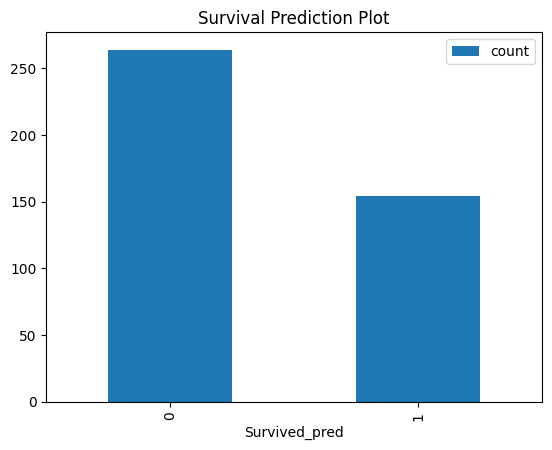

In [57]:
df_final['Survived_pred'].value_counts().plot(kind='bar', title='Survival Prediction Plot', legend='Sex')

###  In this project, we used machine learning techniques to predict the survival of passengers on the Titanic. We used a Support Vector Machine (SVM) classifier to predict the survival of passengers based on their features such as age, sex, and class. The SVM classifier was able to achieve an accuracy of 83%. This suggests that the SVM classifier is able to learn the relationship between the features and the survival of passengers. 